# **Lab Internal - 1 (short codes)**

#1
Implement a basic autoencoder using TensorFlow or PyTorch and train it on a dataset like MNIST for
image reconstruction.

Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 105s 218ms/step - loss: 0.2133 - val_loss: 0.0813
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 222ms/step - loss: 0.0801 - val_loss: 0.0750
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


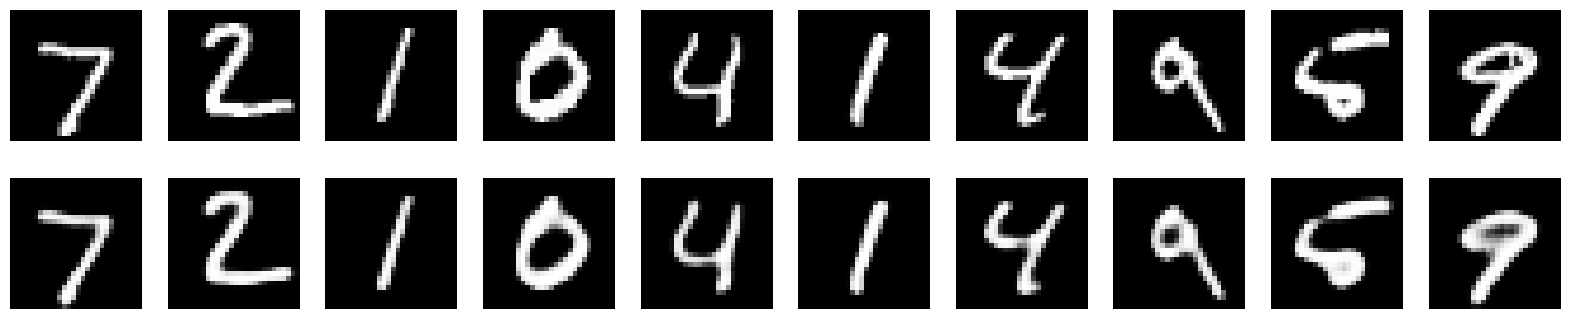

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train[..., np.newaxis] / 255.0
x_test = x_test[..., np.newaxis] / 255.0

# Autoencoder architecture
inp = layers.Input((28,28,1))
x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.Conv2D(16,3,activation='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.Conv2D(16,3,activation='relu',padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32,3,activation='relu',padding='same')(x)
x = layers.UpSampling2D(2)(x)
out = layers.Conv2D(1,3,activation='sigmoid',padding='same')(x)

autoencoder = models.Model(inp, out)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train
autoencoder.fit(x_train, x_train, epochs=2, batch_size=128, validation_data=(x_test, x_test), verbose=1)

# Visualize
decoded = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    ax.axis('off')
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()


#2
Explore different regularization techniques such as L1/L2 regularization or dropout and compare their effects on the autoencoder's performance.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load and preprocess data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

def build_autoencoder(reg_type=None, reg_rate=0.0, dropout_rate=0.0):
    input_img = layers.Input((28, 28, 1))

    if reg_type == 'l1':
        regularizer = regularizers.l1(reg_rate)
    elif reg_type == 'l2':
        regularizer = regularizers.l2(reg_rate)
    elif reg_type == 'l1_l2':
        regularizer = regularizers.l1_l2(l1=reg_rate, l2=reg_rate)
    else:
        regularizer = None

    x = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizer)(input_img)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(16, 3, activation='relu', padding='same', kernel_regularizer=regularizer)(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(16, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded)

def train_autoencoder(config):
    model = build_autoencoder(config['reg_type'], config['reg_rate'], config['dropout_rate'])
    model.compile(optimizer=tf.keras.optimizers.Adam(config['lr']), loss='binary_crossentropy')

    callbacks_list = []
    if config['early_stop']:
        callbacks_list.append(callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

    if config['data_aug']:
        datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
        train_gen = datagen.flow(x_train, x_train, batch_size=128)
        history = model.fit(train_gen, steps_per_epoch=len(x_train)//128, epochs=2, validation_data=(x_test, x_test), callbacks=callbacks_list, verbose=0)
    else:
        history = model.fit(x_train, x_train, epochs=2, batch_size=128, validation_data=(x_test, x_test), callbacks=callbacks_list, verbose=0)

    return round(history.history['loss'][-1], 4), round(history.history['val_loss'][-1], 4)

# Experiment configurations
experiments = [
    {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': 'l1', 'reg_rate': 0.001, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': 'l2', 'reg_rate': 0.001, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': 'l1_l2', 'reg_rate': 0.001, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.3, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': True, 'data_aug': False},
    {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': True},
]

# Run experiments
results = []
for i, config in enumerate(experiments, 1):
    print(f"Experiment {i}: {config}")
    train_loss, val_loss = train_autoencoder(config)

    if config['reg_type']:
        reg_desc = config['reg_type'].upper()
    elif config['dropout_rate'] > 0:
        reg_desc = "Dropout"
    elif config['early_stop']:
        reg_desc = "Early Stopping"
    elif config['data_aug']:
        reg_desc = "Data Augmentation"
    else:
        reg_desc = "None"

    results.append({
        'S.no': i,
        'Regularization': reg_desc,
        'Dropout_rate': config['dropout_rate'],
        'Regularization_rate': config['reg_rate'],
        'Learning_rate': config['lr'],
        'Training_loss': train_loss,
        'Validation_loss': val_loss
    })

# Display results
print("\nResults:")
for r in results:
    print(f"{r['S.no']:2d} | {r['Regularization']:15s} | Dropout: {r['Dropout_rate']:<4} | Reg Rate: {r['Regularization_rate']:<6} | LR: {r['Learning_rate']:<6} | Train Loss: {r['Training_loss']:<6} | Val Loss: {r['Validation_loss']:<6}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Experiment 1: {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False}
Experiment 2: {'reg_type': 'l1', 'reg_rate': 0.001, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False}
Experiment 3: {'reg_type': 'l2', 'reg_rate': 0.001, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False}
Experiment 4: {'reg_type': 'l1_l2', 'reg_rate': 0.001, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False}
Experiment 5: {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.3, 'lr': 0.001, 'early_stop': False, 'data_aug': False}
Experiment 6: {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': True, 'data_aug': False}
Experiment 7: {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': True}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Results:
 1 | None            | Dropout: 0.0  | Reg Rate: 0.0    | LR: 0.001  | Train Loss: 0.0779 | Val Loss: 0.0748
 2 | L1              | Dropout: 0.0  | Reg Rate: 0.001  | LR: 0.001  | Train Loss: 0.0988 | Val Loss: 0.0919
 3 | L2              | Dropout: 0.0  | Reg Rate: 0.001  | LR: 0.001  | Train Loss: 0.0834 | Val Loss: 0.0797
 4 | L1_L2           | Dropout: 0.0  | Reg Rate: 0.001  | LR: 0.001  | Train Loss: 0.0948 | Val Loss: 0.0891
 5 | Dropout         | Dropout: 0.3  | Reg Rate: 0.0    | LR: 0.001  | Train Loss: 0.0857 | Val Loss: 0.0923
 6 | Early Stopping  | Dropout: 0.0  | Reg Rate: 0.0    | LR: 0.001  | Train Loss: 0.0783 | Val Loss: 0.0751
 7 | Data Augmentation | Dropout: 0.0  | Reg Rate: 0.0    | LR: 0.001  | Train Loss: 0.2212 | Val Loss: 0.1704


#

#3
Implement a variational autoencoder (VAE) and train it on a dataset like FashionMNIST to generate
new images.

In [ ]:
import numpy as np, tensorflow as tf, keras
from keras import layers, ops

class Sampling(layers.Layer):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.seed = keras.random.SeedGenerator(1337)  # Create once here
    def call(self, inputs):
        m, s = inputs
        eps = keras.random.normal(ops.shape(m), seed=self.seed)
        return m + s * eps

# Encoder
latent_dim = 2
e_in = keras.Input((28,28,1))
x = layers.Conv2D(32,3,2,"same",activation="relu")(e_in)
x = layers.Conv2D(64,3,2,"same",activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16,activation="relu")(x)
m = layers.Dense(latent_dim)(x)
s = layers.Dense(latent_dim,activation="softplus")(x)
z = Sampling()([m,s])
encoder = keras.Model(e_in, [m, s, z])

# Decoder
d_in = keras.Input((latent_dim,))
x = layers.Dense(7*7*64,activation="relu")(d_in)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64,3,2,"same",activation="relu")(x)
x = layers.Conv2DTranspose(32,3,2,"same",activation="relu")(x)
d_out = layers.Conv2DTranspose(1,3,1,"same",activation="sigmoid")(x)
decoder = keras.Model(d_in, d_out)

# VAE
class VAE(keras.Model):
    def __init__(self, enc, dec, **kw):
        super().__init__(**kw)
        self.enc, self.dec = enc, dec
    def train_step(self, data):
        with tf.GradientTape() as tape:
            m, s, z = self.enc(data)
            r = self.dec(z)
            rl = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, r), axis=(1,2)))
            kl = tf.reduce_mean(tf.reduce_sum(0.5*(s**2+m**2 - 2*tf.math.log(s+1e-8)-1), axis=1))
            loss = rl + kl
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}

# Data
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
data = np.expand_dims(np.concatenate([x_train, x_test])/255.0, -1)

# Train
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(data, epochs=2, batch_size=128)


Epoch 1/2
547/547 ━━━━━━━━━━━━━━━━━━━━ 99s 172ms/step - loss: 211.6020
Epoch 2/2
547/547 ━━━━━━━━━━━━━━━━━━━━ 141s 170ms/step - loss: 177.6003


Enter index: 1


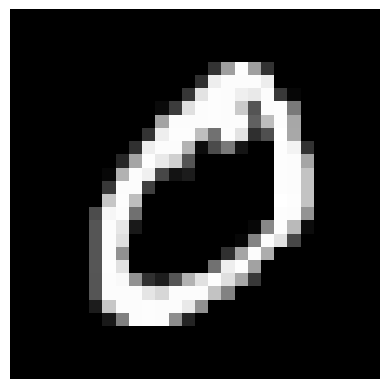

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


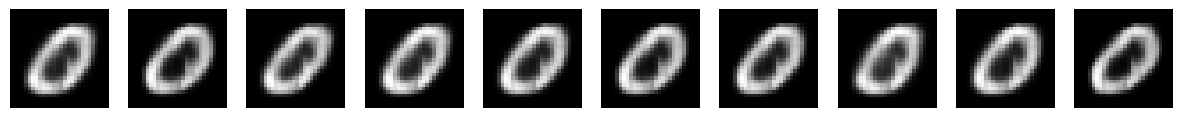

In [ ]:
# Generate Variations
idx = int(input("Enter index: "))
if not 0 <= idx < len(data): raise ValueError("Index out of range")
img = data[idx:idx+1]
plt.imshow(img[0].squeeze(), cmap="gray"); plt.axis("off"); plt.show()
m, s, _ = encoder.predict(img)
noise = np.random.normal(size=(10, latent_dim))
z_vars = m + s * noise
gen = decoder.predict(z_vars)
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(gen[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()

#4
Implement a basic autoregressive model like the Fully Visible Sigmoid Belief Network (FVSBN) using
PyTorch or TensorFlow and train it on a sequential dataset like time series data.

Epoch 2, Loss: 0.3620
Epoch 4, Loss: 0.3050
Epoch 6, Loss: 0.2736
Epoch 8, Loss: 0.2511
Epoch 10, Loss: 0.2332
Log prob: -188.82222


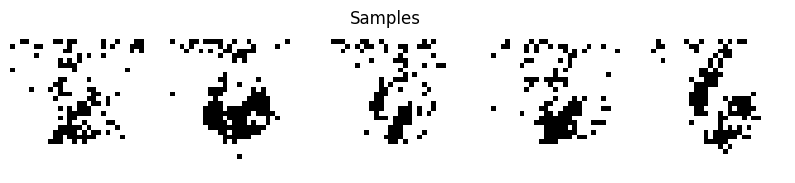

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

class FVSBNLayer(tf.keras.layers.Layer):
    def __init__(self, dim):
        super().__init__(); self.dim = dim
        self.mask = tf.constant(np.tril(np.ones((dim, dim)), -1), tf.float32)
    def build(self, _):
        self.k = self.add_weight(name="k", shape=(self.dim, self.dim), initializer="random_normal")
        self.b = self.add_weight(name="b", shape=(self.dim,), initializer="zeros")
    def call(self, x):
        return tf.matmul(x, self.k * self.mask, transpose_b=True) + self.b

class FVSBN(tf.keras.Model):
    def __init__(self, dim):
        super().__init__(); self.l = FVSBNLayer(dim)
    def call(self, x):
        return tf.nn.sigmoid(self.l(x))
    def compute_loss(self, x):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)(x, self.l(x))
    def sample(self, n):
        s = tf.zeros((n, self.l.dim))
        for i in range(self.l.dim):
            p = self(s)[:, i]
            s = tf.tensor_scatter_nd_update(s, [[j,i] for j in range(n)],
                tf.cast(tfp.distributions.Bernoulli(probs=p).sample(), tf.float32))
        return s

def load_data():
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
    f = lambda x: (x/255.>0.5).astype(np.float32).reshape(-1,784)
    return f(x_train)[:10000], f(x_test)[:1000]

def train(model, data, e=10, b=128, lr=0.001):
    opt = tf.keras.optimizers.Adam(lr)
    for epoch in range(e):
        ds = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(b)
        total = 0
        for x in ds:
            with tf.GradientTape() as tape:
                loss = model.compute_loss(x)
            opt.apply_gradients(zip(tape.gradient(loss, model.trainable_variables), model.trainable_variables))
            total += loss.numpy()
        if (epoch+1)%2==0: print(f"Epoch {epoch+1}, Loss: {total/len(ds):.4f}")

def visualize(s, t="Samples"):
    plt.figure(figsize=(10,2))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(s[i].numpy().reshape(28,28), "binary")
        plt.axis("off")
    plt.suptitle(t)
    plt.show()

if __name__ == "__main__":
    tf.random.set_seed(42); np.random.seed(42)
    dim = 784; x_train, x_test = load_data()
    model = FVSBN(dim)
    train(model, x_train)
    print("Log prob:", (-model.compute_loss(x_test[:1])*dim).numpy())
    visualize(model.sample(5))

#5
Implement NADE and train it on a dataset like CIFAR-10 for image generation.


Training NADE (Optimized)...
Epoch 1/5 | Loss: 0.3675
Epoch 2/5 | Loss: 0.2601
Epoch 3/5 | Loss: 0.2448
Epoch 4/5 | Loss: 0.2306
Epoch 5/5 | Loss: 0.2171


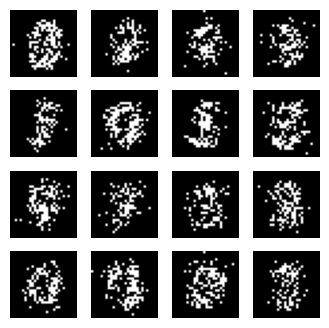

Final Sampling...


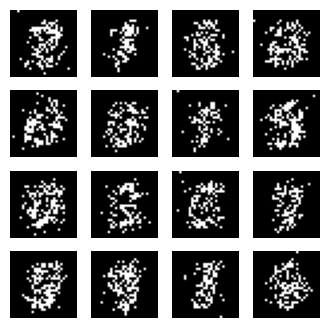

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Force float32 globally
tf.keras.mixed_precision.set_global_policy('float32')
tf.config.optimizer.set_jit(False)

# --------------------------- Data Loader ---------------------------
def load_binarized_mnist(train_size=5000, test_size=500):
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train / 255.0).reshape(-1, 28*28)
    x_test = (x_test / 255.0).reshape(-1, 28*28)
    x_train = (x_train > 0.5).astype(np.float32)[:train_size]
    x_test = (x_test > 0.5).astype(np.float32)[:test_size]
    return x_train, x_test

# --------------------------- NADE Model ---------------------------
class NADE(tf.keras.Model):
    def __init__(self, D, H):
        super().__init__()
        self.D, self.H = D, H
        self.W = self.add_weight(name="W", shape=(H, D), initializer="glorot_uniform")
        self.V = self.add_weight(name="V", shape=(H, D), initializer="glorot_uniform")
        self.c = self.add_weight(name="c", shape=(H,), initializer="zeros")
        self.b = self.add_weight(name="b", shape=(D,), initializer="zeros")

    @tf.function
    def call(self, x):
        batch_size = tf.shape(x)[0]
        a = tf.tile(self.c[None, :], [batch_size, 1])
        outputs = tf.TensorArray(dtype=tf.float32, size=self.D)

        for i in tf.range(self.D):
            h = tf.nn.sigmoid(a)
            logit = tf.einsum('bh,h->b', h, self.V[:, i]) + self.b[i]
            prob = tf.nn.sigmoid(logit)[:, None]
            outputs = outputs.write(i, prob)
            a = a + x[:, i:i+1] @ tf.transpose(self.W[:, i:i+1])

        return tf.transpose(outputs.stack(), [1, 0, 2])[:, :, 0]

    @tf.function
    def compute_loss(self, x):
        probs = self(x)
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, probs))

# --------------------------- Training ---------------------------
def train_model(model, x_train, epochs=30, batch_size=256, lr=2e-3, visualize_every=5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    for epoch in range(epochs):
        losses = []
        for step, batch in enumerate(dataset):
            with tf.GradientTape() as tape:
                loss = model.compute_loss(batch)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            losses.append(loss.numpy())

        print(f"Epoch {epoch+1}/{epochs} | Loss: {np.mean(losses):.4f}")

        # Optional visualization every few epochs
        if (epoch+1) % visualize_every == 0:
            visualize_samples(model)

def visualize_samples(model, num_samples=16):
    samples = model_sample(model, num_samples)
    plt.figure(figsize=(4, 4))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(samples[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

def model_sample(model, num_samples=16):
    D = model.D
    x = tf.zeros((num_samples, D), dtype=tf.float32)
    a = tf.tile(model.c[None, :], [num_samples, 1])

    for i in range(D):
        h = tf.nn.sigmoid(a)
        logit = tf.einsum('bh,h->b', h, model.V[:, i]) + model.b[i]
        prob = tf.nn.sigmoid(logit)
        xi = tf.cast(tf.random.uniform((num_samples,)) < prob, tf.float32)
        x = tf.concat([x[:, :i], xi[:, None], x[:, i+1:]], axis=1) # Corrected line
        a = a + xi[:, None] @ tf.transpose(model.W[:, i:i+1])
    return x.numpy()

# --------------------------- Main ---------------------------
x_train, x_test = load_binarized_mnist()
D = x_train.shape[1]

print("\nTraining NADE (Optimized)...")
nade = NADE(D=D, H=256)
train_model(nade, x_train, epochs=5, batch_size=256, lr=2e-3, visualize_every=5)

print("Final Sampling...")
visualize_samples(nade)

#6
Implement MADE and train it on a dataset like CelebA for image generation.

Epoch 1/10 - loss: 0.6932
Epoch 2/10 - loss: 0.6932
Epoch 3/10 - loss: 0.6932
Epoch 4/10 - loss: 0.6932
Epoch 5/10 - loss: 0.6932
Epoch 6/10 - loss: 0.6932
Epoch 7/10 - loss: 0.6932
Epoch 8/10 - loss: 0.6932
Epoch 9/10 - loss: 0.6932
Epoch 10/10 - loss: 0.6932


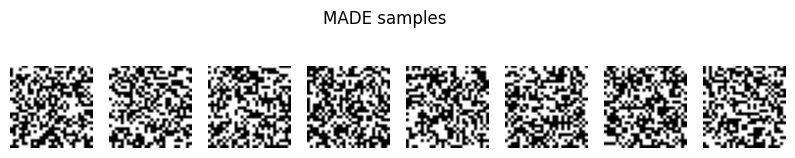

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Data ----------------
def load_binarized_mnist(train_size=5000, test_size=500):
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    x_train = ((x_train/255.0) > 0.5).astype(np.float32).reshape(-1, 28*28)
    return x_train[:train_size]

def visualize_samples(samples, title="Samples"):
    samples = samples.reshape(-1,28,28)
    plt.figure(figsize=(10,2))
    for i in range(min(8,samples.shape[0])):
        plt.subplot(1,min(8,samples.shape[0]),i+1)
        plt.imshow(samples[i],cmap="binary"); plt.axis("off")
    plt.suptitle(title); plt.show()

# ---------------- MADE ----------------
class MADE(tf.keras.Model):
    def __init__(self, D, H, seed=None):
        super().__init__()
        self.D, self.H = D,H
        rng = np.random.RandomState(seed)
        self.deg_input = np.arange(1,D+1)
        self.deg_hidden = rng.randint(1,D,size=H)
        self.deg_output = np.arange(1,D+1)

        self.W_in_hid = self.add_weight(name="W_in_hid", shape=(D,H),
                                        initializer="glorot_uniform")
        self.b_hid = self.add_weight(name="b_hid", shape=(H,), initializer="zeros")
        self.W_hid_out = self.add_weight(name="W_hid_out", shape=(H,D),
                                         initializer="glorot_uniform")
        self.b_out = self.add_weight(name="b_out", shape=(D,), initializer="zeros")

        self.mask_in_hid = (self.deg_input[:,None]<=self.deg_hidden[None,:]).astype(np.float32)
        self.mask_hid_out = (self.deg_hidden[:,None]<self.deg_output[None,:]).astype(np.float32)

    def call(self,x):
        h = tf.nn.relu(tf.matmul(x,self.W_in_hid*self.mask_in_hid)+self.b_hid)
        out = tf.matmul(h,self.W_hid_out*self.mask_hid_out)+self.b_out
        return tf.nn.sigmoid(out)

    def compute_loss(self,x):
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(x,self(x)))

    def sample(self,n):
        x = np.zeros((n,self.D),np.float32)
        for i in range(self.D):
            probs = self(x)[:,i]
            x[:,i] = tfp.distributions.Bernoulli(probs=probs).sample().numpy()
        return x

# ---------------- Training ----------------
def train_model(model,x_train,epochs=3,batch_size=128,lr=1e-3):
    opt = tf.keras.optimizers.Adam(lr)
    ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)
    for e in range(epochs):
        loss = np.mean([model.compute_loss(batch).numpy() for batch in ds])
        print(f"Epoch {e+1}/{epochs} - loss: {loss:.4f}")

# ---------------- Main ----------------
if __name__=="__main__":
    tf.random.set_seed(0); np.random.seed(0)
    x_train = load_binarized_mnist(train_size=2000)
    made = MADE(D=28*28,H=400,seed=2)
    train_model(made,x_train,epochs=10,batch_size=128,lr=1e-3)
    visualize_samples(made.sample(8), title="MADE samples")


#7
Implement a Vanilla GAN using TensorFlow or PyTorch and train it on a dataset like CIFAR-10 for image generation.

Epoch 1 - G Loss: 0.8322, D Loss: 1.3536


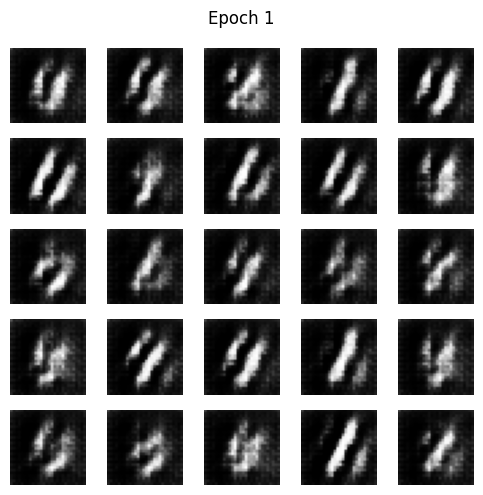

Epoch 5 - G Loss: 0.8437, D Loss: 1.3387


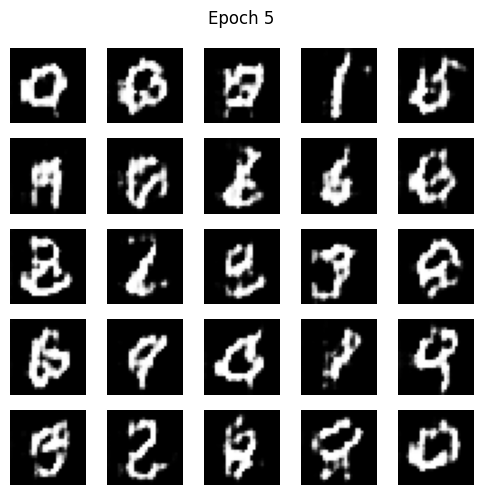

Epoch 10 - G Loss: 0.7752, D Loss: 1.4098


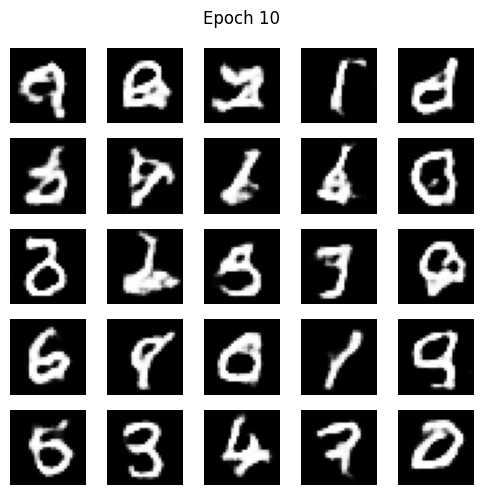

Epoch 15 - G Loss: 0.9234, D Loss: 1.3153


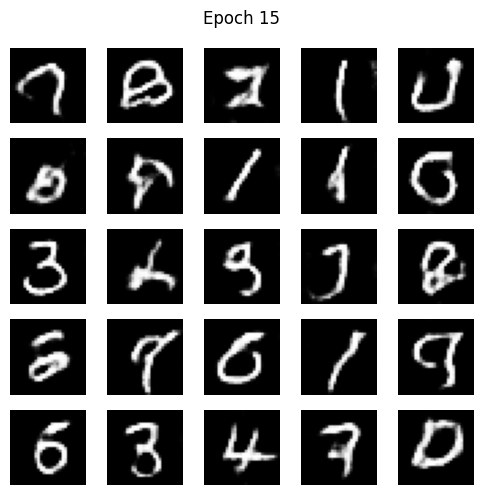

Epoch 20 - G Loss: 0.8669, D Loss: 1.2354


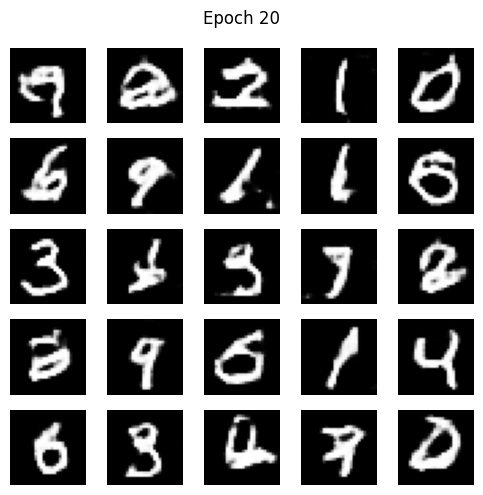

Epoch 25 - G Loss: 0.8743, D Loss: 1.3442


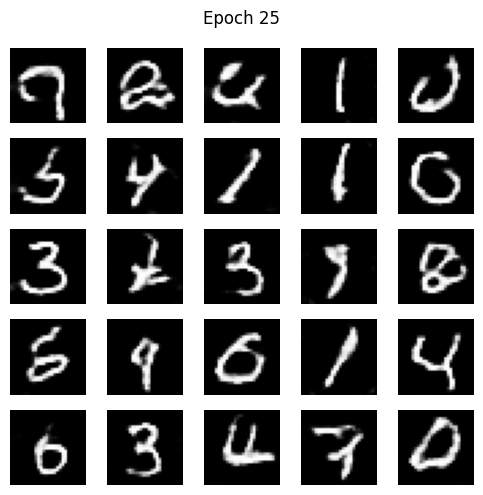

Epoch 30 - G Loss: 0.8724, D Loss: 1.3735


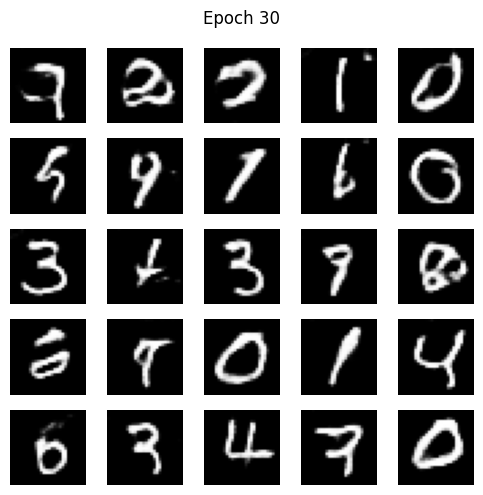

Epoch 35 - G Loss: 0.8413, D Loss: 1.3126


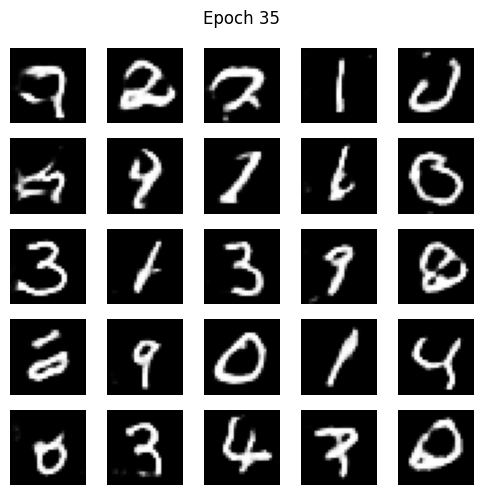

Epoch 40 - G Loss: 0.8523, D Loss: 1.3181


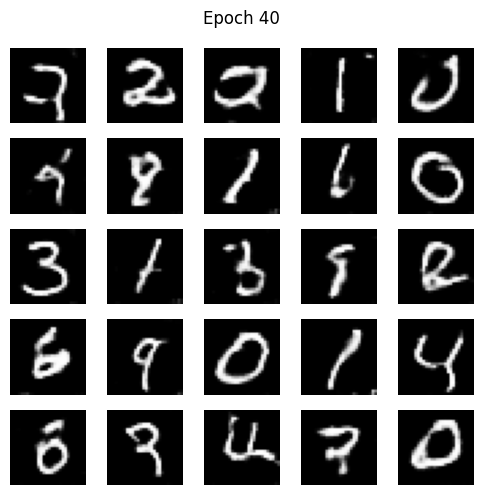

Epoch 45 - G Loss: 0.7898, D Loss: 1.3774


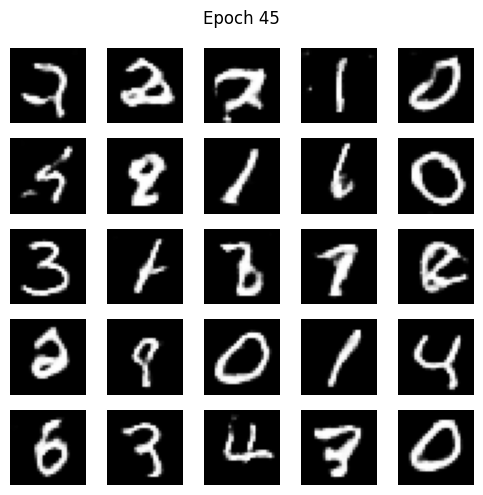

Epoch 50 - G Loss: 0.8260, D Loss: 1.3516


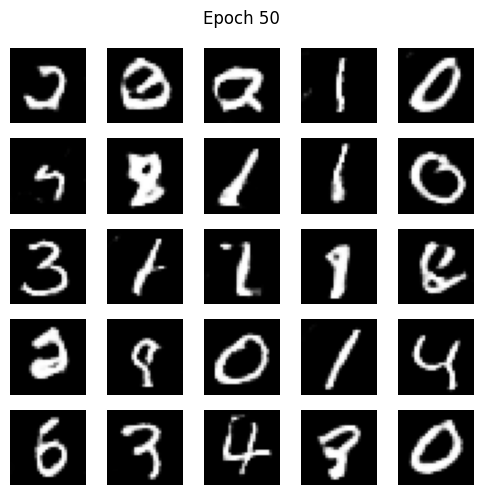

Training completed!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Config
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

EPOCHS = 50
BATCH_SIZE = 256
NOISE_DIM = 100
LR = 2e-4
BETA_1 = 0.5

# Data
(x_train, _), _ = keras.datasets.mnist.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, -1)
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

# Generator
def build_generator():
    return keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((7,7,256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])

# Discriminator
def build_discriminator():
    return keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28,28,1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

generator = build_generator()
discriminator = build_discriminator()

# Losses & Optimizers
bce = keras.losses.BinaryCrossentropy()
g_opt = keras.optimizers.Adam(LR, beta_1=BETA_1)
d_opt = keras.optimizers.Adam(LR, beta_1=BETA_1)

def d_loss(real_out, fake_out):
    real_loss = bce(tf.ones_like(real_out)*0.9, real_out)  # label smoothing
    fake_loss = bce(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

def g_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

# Training step
@tf.function
def train_step(real_imgs):
    noise = tf.random.normal([real_imgs.shape[0], NOISE_DIM])
    with tf.GradientTape() as gt, tf.GradientTape() as dt:
        fake_imgs = generator(noise, training=True)
        real_out = discriminator(real_imgs, training=True)
        fake_out = discriminator(fake_imgs, training=True)
        gl = g_loss(fake_out)
        dl = d_loss(real_out, fake_out)
    g_grads = gt.gradient(gl, generator.trainable_variables)
    d_grads = dt.gradient(dl, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return gl, dl

# Plotting generated images
seed = tf.random.normal([25, NOISE_DIM])
def sample_images(epoch):
    preds = generator(seed, training=False)
    plt.figure(figsize=(5,5))
    for i in range(25):
        plt.subplot(5,5,i+1)
        img = (preds[i] + 1) / 2.0
        plt.imshow(img.numpy().squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.show()

# Training loop
def train():
    for epoch in range(1, EPOCHS+1):
        for real_batch in train_ds:
            gl, dl = train_step(real_batch)
        if epoch % 5 == 0 or epoch == 1 or epoch == EPOCHS:
            print(f'Epoch {epoch} - G Loss: {gl:.4f}, D Loss: {dl:.4f}')
            sample_images(epoch)

# Run
train()
print("Training completed!")
